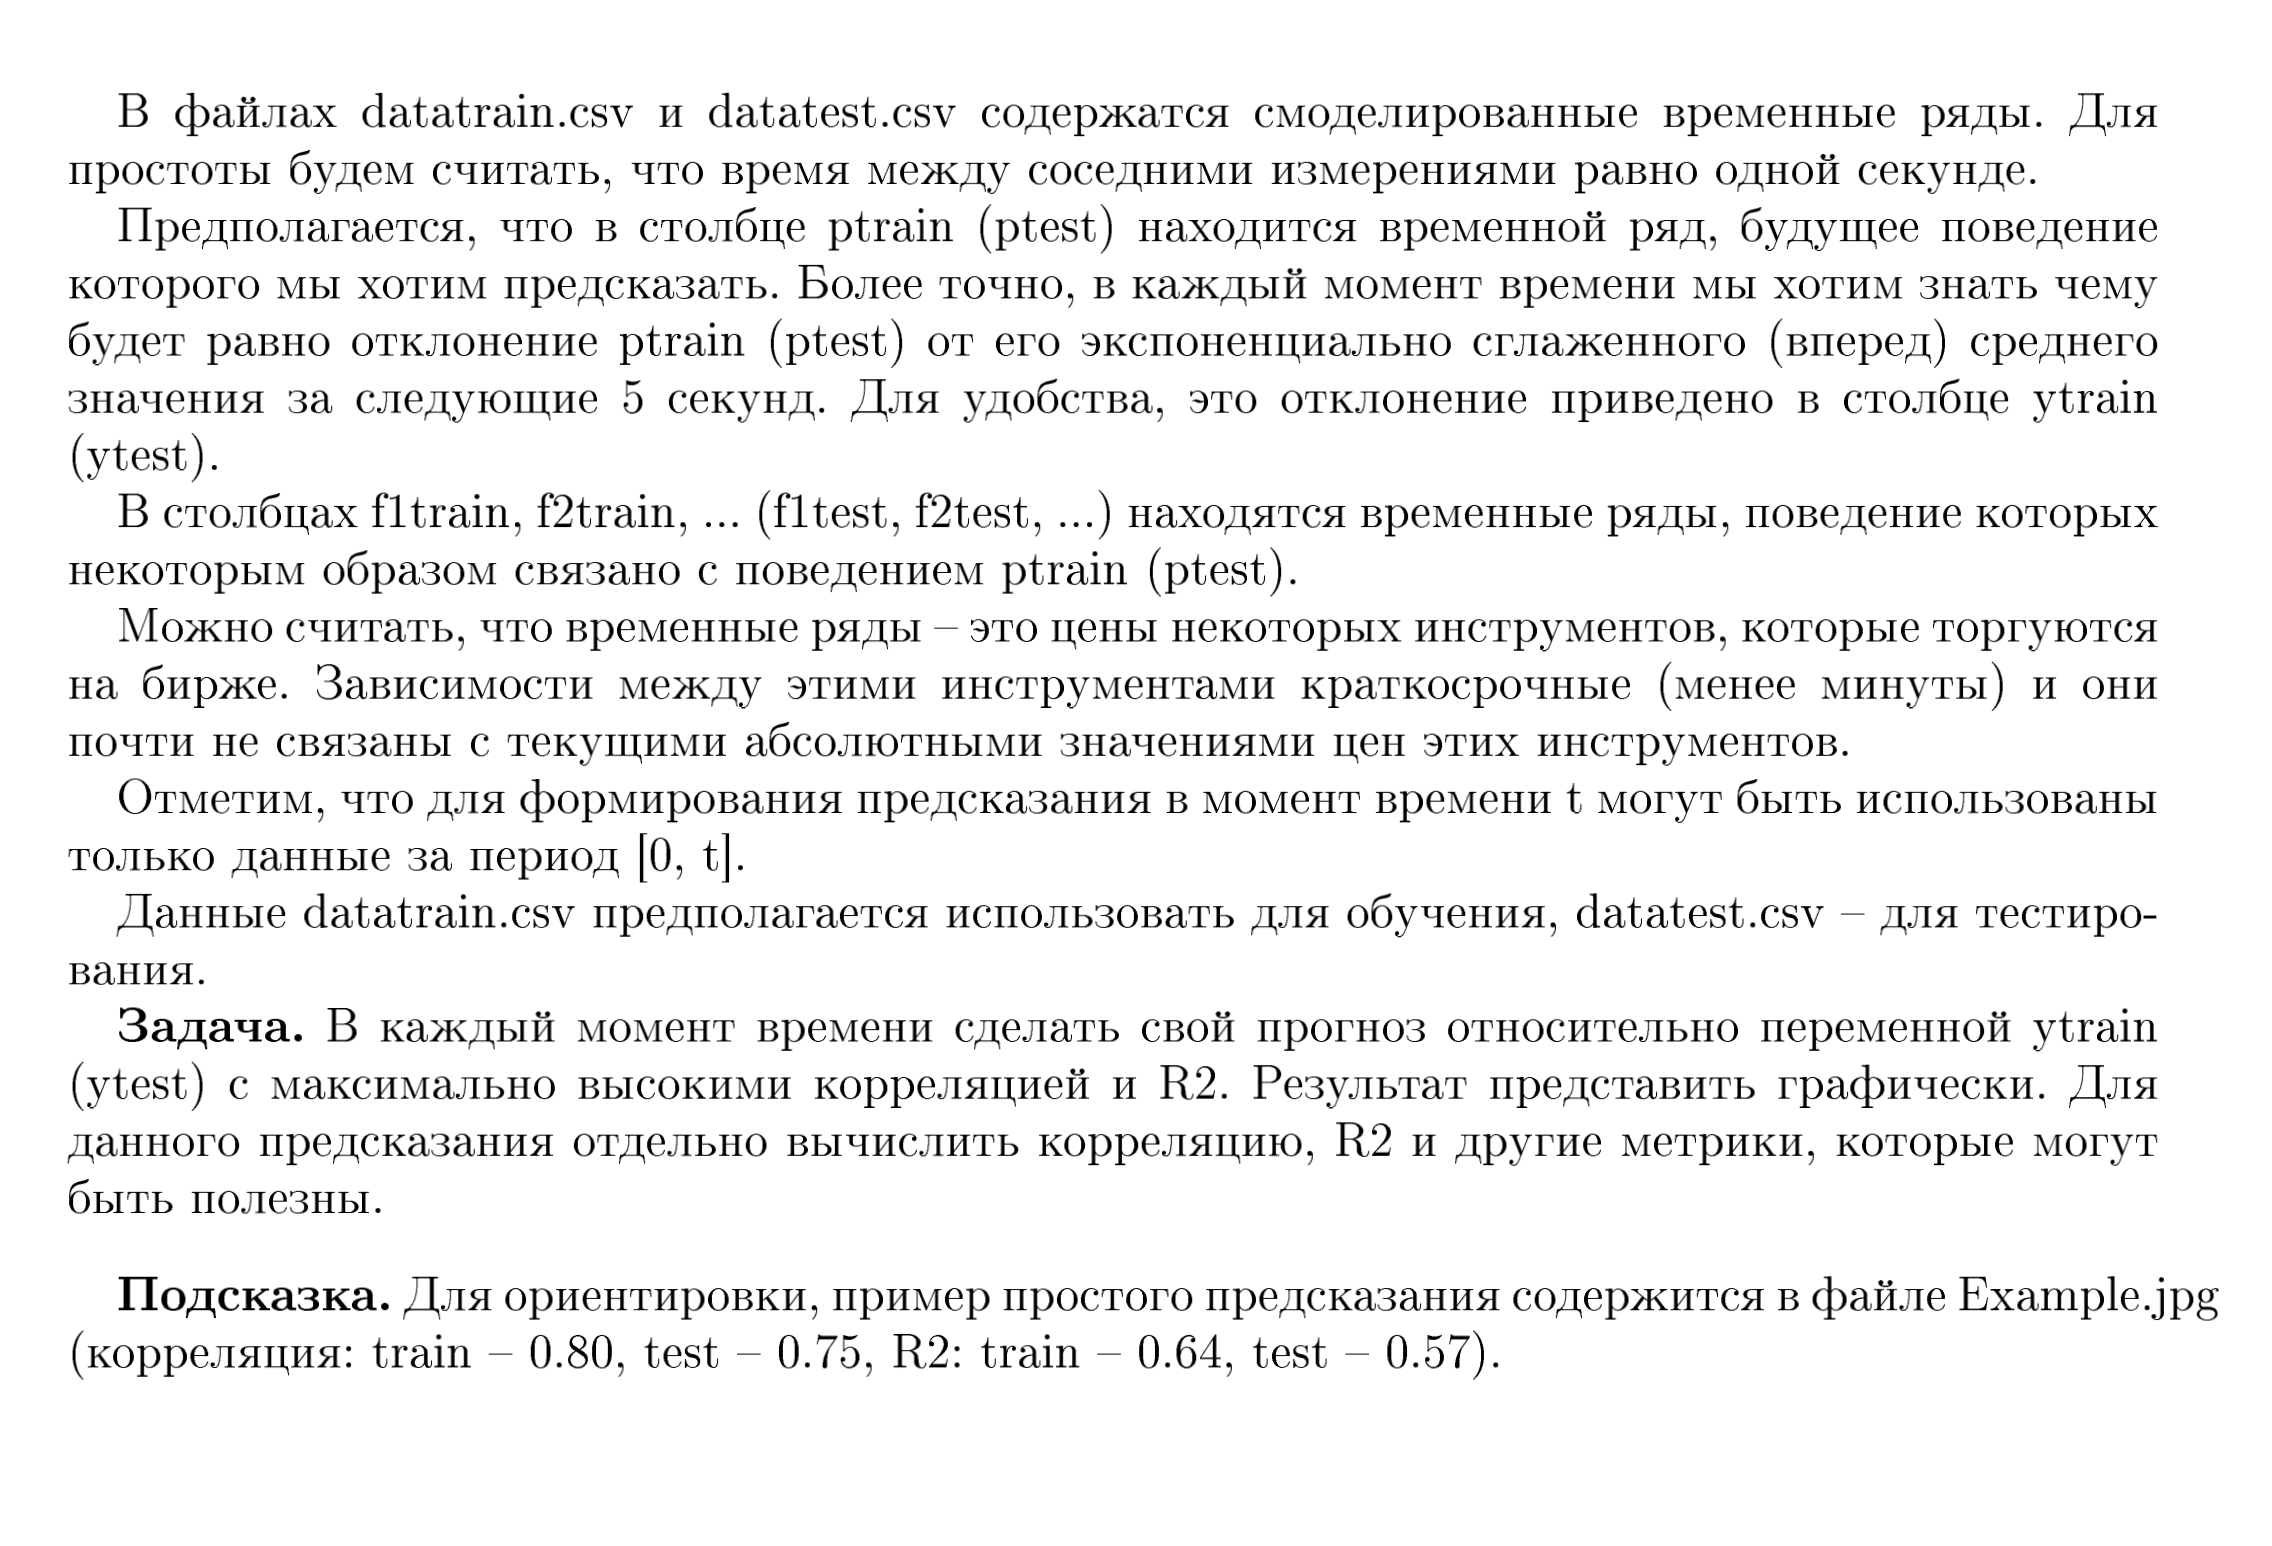

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib.pyplot import figure
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from fastprogress import master_bar, progress_bar
from torch.autograd import Variable


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


torch.cuda.empty_cache()

Fri Mar 19 17:14:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = 'cuda'

In [ ]:

train = pd.read_csv(r'datatrain.csv')
# to perform fast train without batching I used 
# train = train.head(round(len(train)/10)) 
print('length of the dataset: %d'%(len(train)))
print('number of dims: %d' % (len(train.columns)))
train

length of the dataset: 100000
number of dims: 7


ytrain       ptrain  ...      f4train      f5train
0      0.673637  1074.969347  ...  2082.532820  1291.340172
1      0.058719  1075.594908  ...  2082.842577  1291.484252
2      0.381526  1075.341261  ...  2083.098220  1291.687519
3      0.528869  1075.289785  ...  2083.308693  1291.672426
4      1.024721  1074.979684  ...  2082.966599  1292.210891
...         ...          ...  ...          ...          ...
99995  4.394729   606.230879  ...  2496.313241  1038.019063
99996 -5.086114   614.789765  ...  2495.404075  1038.397075
99997 -2.914693   612.090000  ...  2493.039978  1039.322930
99998  2.912018   606.791149  ...  2492.987647  1039.806433
99999  0.000000   609.703167  ...  2490.973166  1040.874883

[100000 rows x 7 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train['ytrain'] \
                                             .values.astype(float) \
                                             .reshape(-1, 1))


print(train_data_normalized)

[[ 0.00680915]
 [-0.0243104 ]
 [-0.00797392]
 ...
 [-0.17478801]
 [ 0.12008853]
 [-0.02728206]]


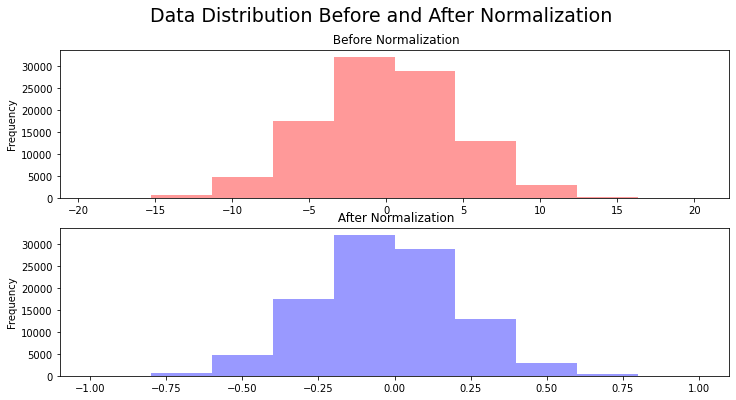

In [ ]:


fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(train['ytrain']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], 
                        legend = False,
                        title = ' Before Normalization',
                        color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', 
                                         ax = axs[1] ,
                                         figsize=[12,6], 
                                         alpha=.4 , 
                                         legend = False,
                                         title = ' After Normalization'\
                                         ,color = 'blue')

In [ ]:
# sliding window to make learning "attentive"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

In [ ]:
# sequencing 
seq_length = 60
x, y = sliding_windows(train_data_normalized, 
                       seq_length)


print(x.shape)
print(y.shape)

(99939, 60, 1)
(99939, 1)


In [ ]:
# adding training and validation (not test) data

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([66959, 60, 1])
train label shape is: torch.Size([66959, 1])
test shape is: torch.Size([32980, 60, 1])
test label shape is: torch.Size([32980, 1])


In [ ]:
# creation of dataloader for using batches to train using gpu memory 
train_data = []
for i in range(len(trainY)):
   train_data.append([trainX[i], trainY[i]])

trainloader = torch.utils.data.DataLoader(train_data, 
                                          shuffle=True, 
                                          batch_size=1000)
i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([1000, 60, 1])


In [ ]:
trainloader

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:

num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

# Init the Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

# Set Criterion Optimzer and scheduler
criterion = torch.nn.MSELoss().to(device)   
optimizer = torch.optim.Adam(lstm.parameters(), 
                             lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  
                                                       patience=500,
                                                       factor =0.5 ,
                                                       min_lr=1e-7, 
                                                       eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    # Launching batches 
    for local_batch, local_labels in trainloader:
        # Transfer to GPU
        lstm.train()
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = lstm(local_batch.to(device))
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, local_labels.to(device))

        loss.backward()
    
    
        optimizer.step()
    
        #Evaluate on test     
        lstm.eval()
        valid = lstm(local_batch.to(device))
        vall_loss = criterion(valid, local_labels.to(device))
        scheduler.step(vall_loss)
    
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1



Epoch: 0, loss: 0.05101 valid loss:  0.04984 
Epoch: 10, loss: 0.04804 valid loss:  0.04640 
Epoch: 20, loss: 0.04548 valid loss:  0.04438 
Epoch: 30, loss: 0.04880 valid loss:  0.04768 
Epoch: 40, loss: 0.04610 valid loss:  0.04503 
Epoch: 50, loss: 0.04656 valid loss:  0.04484 
Epoch: 60, loss: 0.04552 valid loss:  0.04424 
Epoch: 70, loss: 0.04790 valid loss:  0.04640 
Epoch: 80, loss: 0.04662 valid loss:  0.04548 
Epoch: 90, loss: 0.04815 valid loss:  0.04649 
Epoch: 100, loss: 0.04822 valid loss:  0.04760 
Epoch: 110, loss: 0.04698 valid loss:  0.04449 
Epoch: 120, loss: 0.05041 valid loss:  0.04904 
Epoch: 130, loss: 0.04646 valid loss:  0.04565 
Epoch: 140, loss: 0.04642 valid loss:  0.04473 
Epoch: 150, loss: 0.05329 valid loss:  0.05173 
Epoch: 160, loss: 0.05024 valid loss:  0.04878 
Epoch: 170, loss: 0.04766 valid loss:  0.04648 
Epoch: 180, loss: 0.04886 valid loss:  0.04806 
Epoch: 190, loss: 0.04974 valid loss:  0.04890 
Epoch: 200, loss: 0.04667 valid loss:  0.04600 
Epo

## Тesting

In [ ]:
# uploading test data
test = pd.read_csv(r'datatest.csv')

test = test.head(round(len(test)/4))
test_data_normalized = scaler.fit_transform(test['ytest'] \
                                             .values.astype(float) \
                                             .reshape(-1, 1))

test__x, test__y = sliding_windows(test_data_normalized, 
                                   seq_length)

test_dataX = Variable(torch.Tensor(np.array(test__x)))
test_dataY = Variable(torch.Tensor(np.array(test__y)))

test_size = len(test__y)



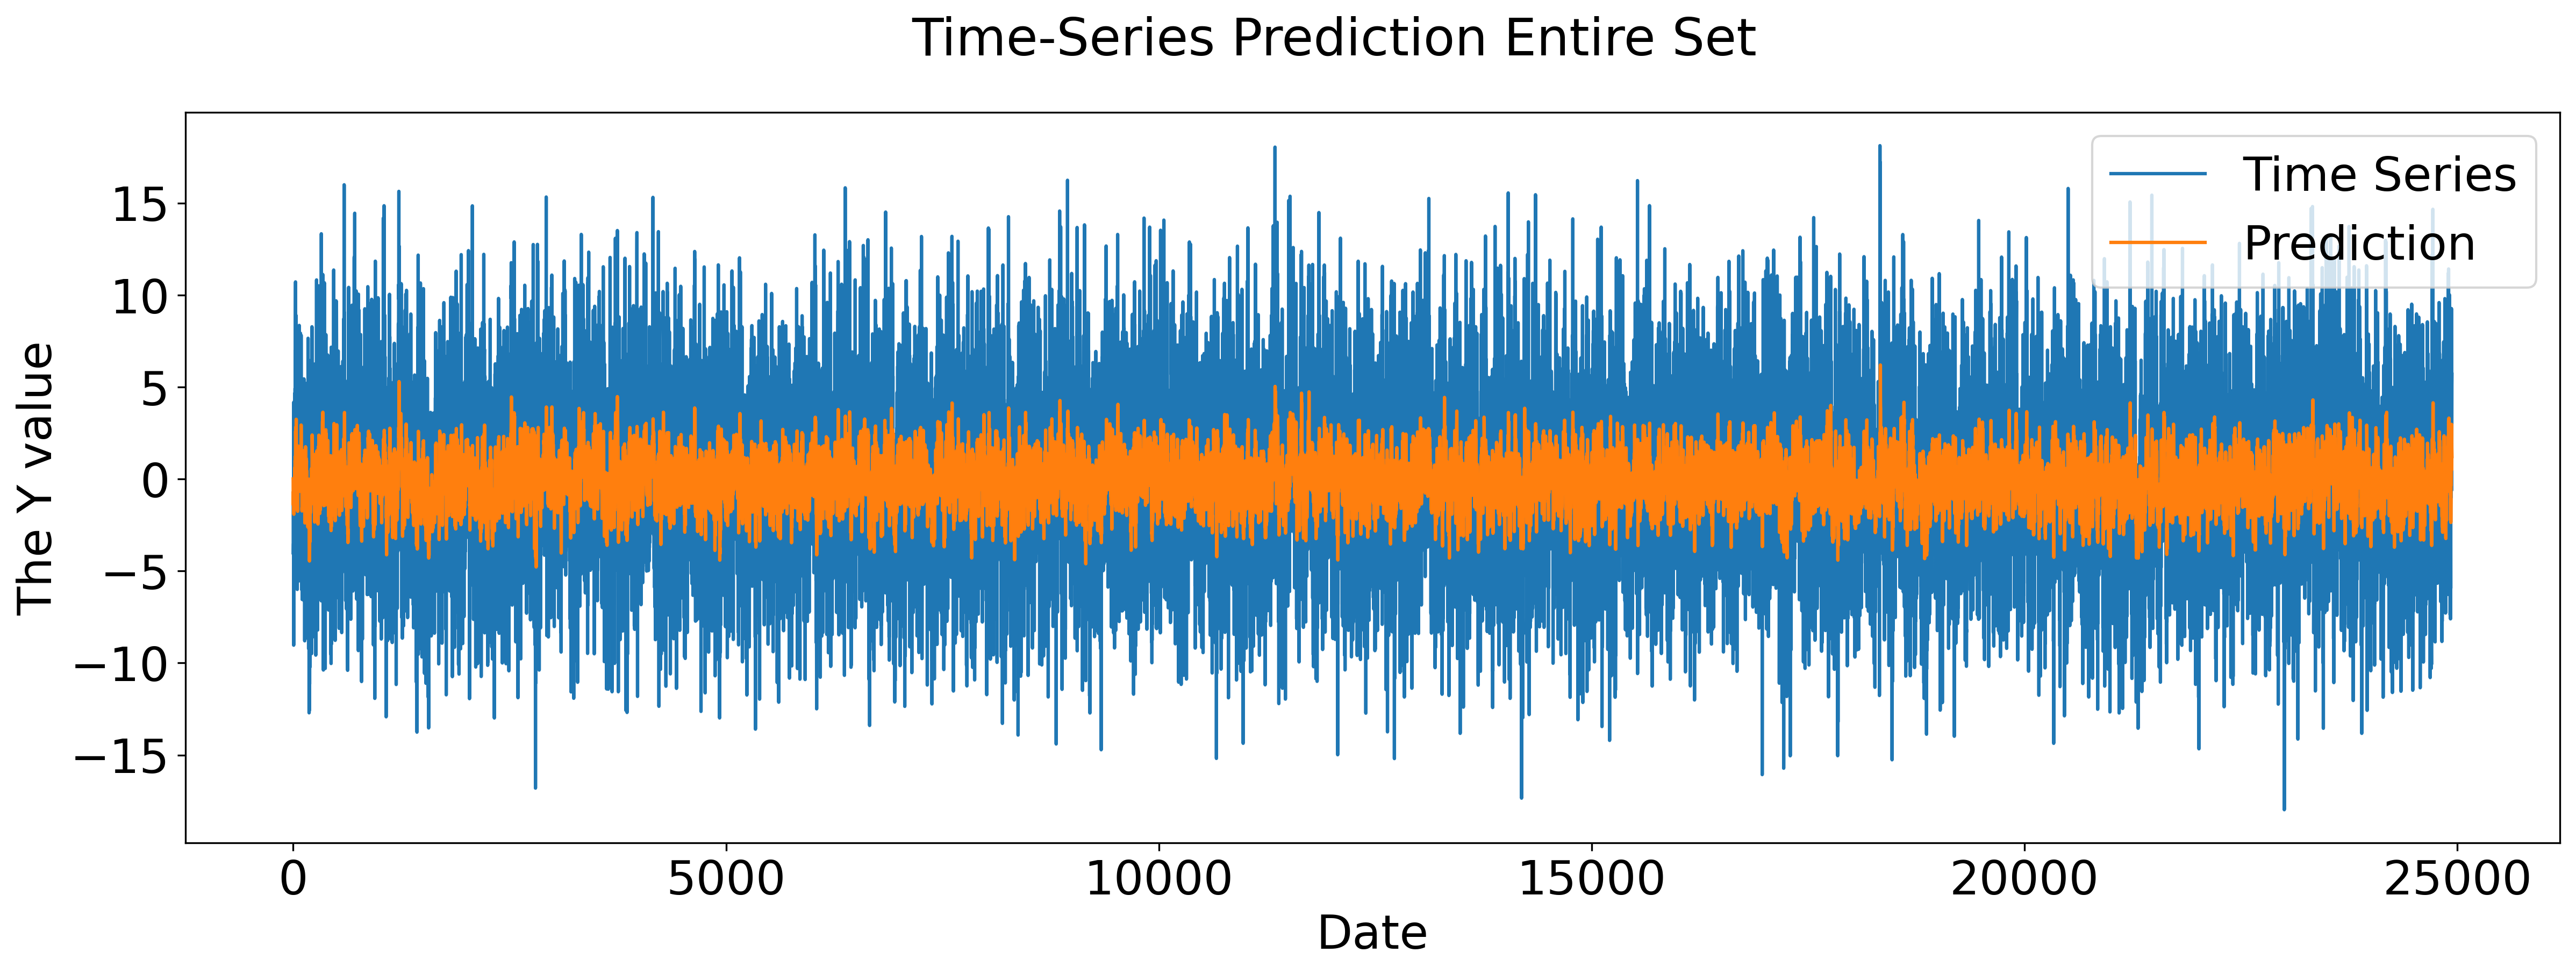

In [ ]:
# Prediction

lstm.eval()
test_predict = lstm(test_dataX.to(device))
data_predict = test_predict.cpu().data.numpy()
dataY_plot = test_dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_labels = pd.DataFrame(dataY_plot)

# Plot 
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series', 'Prediction',],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

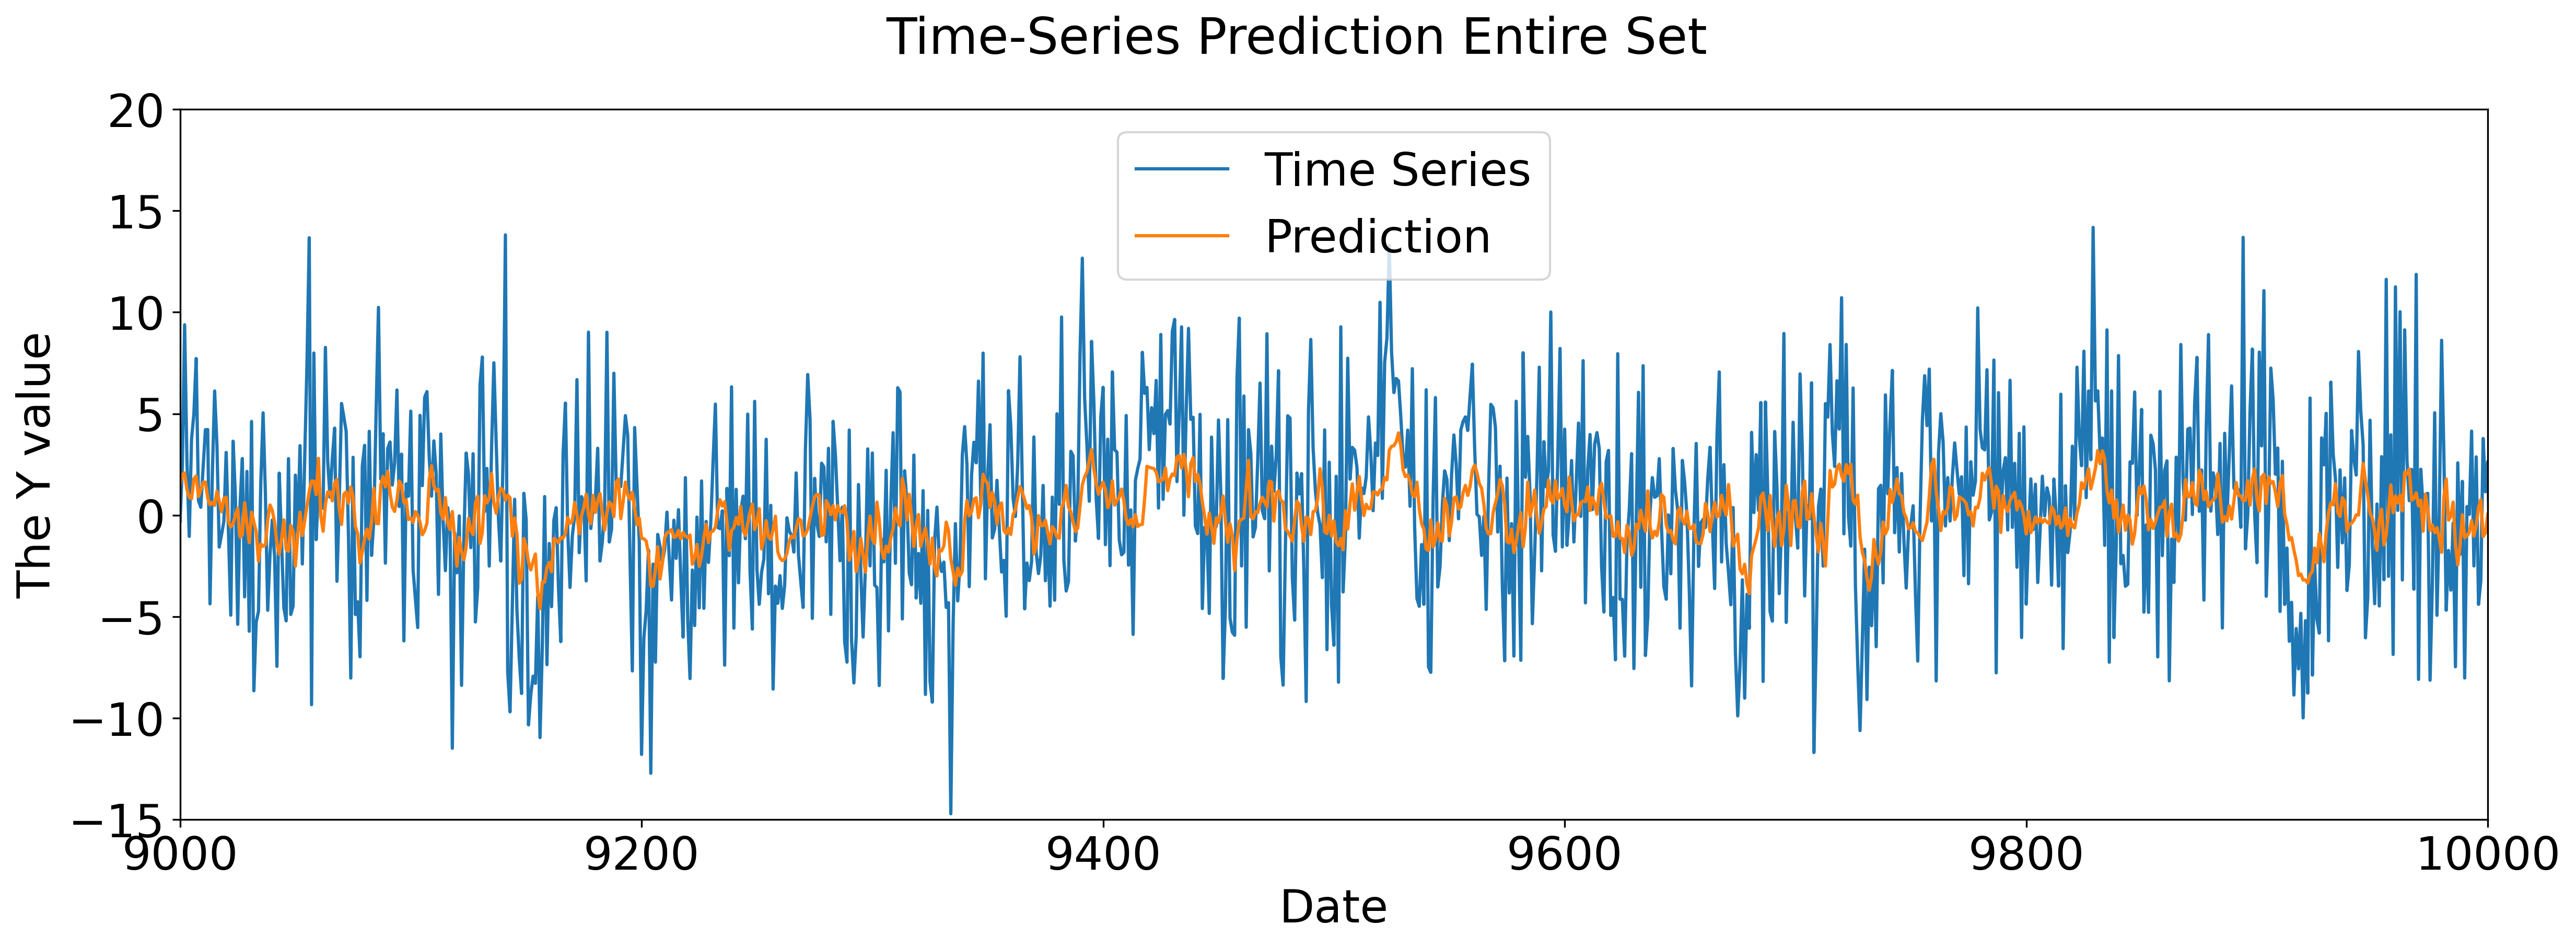

In [ ]:
# Plot of last 10000 iterations
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.axis([9000, 10000, -15, 20])
plt.show()

In [ ]:

print('root mean square error: ', mean_squared_error(df_labels[0], df_predict[0]))
print('R2: ',r2_score(df_labels[0], df_predict[0]))


root mean square error:  18.069796
R2:  0.12621395141926284


In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out
    
   
        

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
num_epochs = 600
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 3

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
  for local_batch, local_labels in trainloader:
        # Transfer to GPU
        lstm.train()
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = lstm(local_batch.to(device))
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)

        # obtain the loss function
        loss = criterion(outputs, local_labels.to(device))

        loss.backward()
    
        scheduler.step(loss)
        optimizer.step()
    
        # Evaluate on validation data  
        lstm.eval()
        valid = lstm(local_batch.to(device))
        vall_loss = criterion(valid, local_labels.to(device))
        scheduler.step(vall_loss)
    
  if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))
    

Epoch: 0, loss: 0.04873 valid loss:  0.04869 
Epoch: 10, loss: 0.04661 valid loss:  0.04659 
Epoch: 20, loss: 0.04784 valid loss:  0.04768 
Epoch: 30, loss: 0.04892 valid loss:  0.04893 
Epoch: 40, loss: 0.04691 valid loss:  0.04695 
Epoch: 50, loss: 0.04769 valid loss:  0.04774 
Epoch: 60, loss: 0.04891 valid loss:  0.04877 
Epoch: 70, loss: 0.04679 valid loss:  0.04683 
Epoch: 80, loss: 0.04583 valid loss:  0.04574 
Epoch: 90, loss: 0.04986 valid loss:  0.04983 
Epoch: 100, loss: 0.04998 valid loss:  0.05000 
Epoch: 110, loss: 0.05125 valid loss:  0.05141 
Epoch: 120, loss: 0.04612 valid loss:  0.04610 
Epoch: 130, loss: 0.04685 valid loss:  0.04684 
Epoch: 140, loss: 0.04379 valid loss:  0.04362 
Epoch: 150, loss: 0.04537 valid loss:  0.04537 
Epoch: 160, loss: 0.04767 valid loss:  0.04775 
Epoch: 170, loss: 0.04678 valid loss:  0.04661 
Epoch: 180, loss: 0.04754 valid loss:  0.04748 
Epoch: 190, loss: 0.04811 valid loss:  0.04807 
Epoch: 200, loss: 0.04483 valid loss:  0.04472 
Epo

Epoch: 520, loss: 0.04535 valid loss:  0.04523 
Epoch: 530, loss: 0.04788 valid loss:  0.04763 
Epoch: 540, loss: 0.04762 valid loss:  0.04753 
Epoch: 550, loss: 0.04400 valid loss:  0.04382 
Epoch: 560, loss: 0.04564 valid loss:  0.04575 
Epoch: 570, loss: 0.04815 valid loss:  0.04799 
Epoch: 580, loss: 0.04729 valid loss:  0.04718 
Epoch: 590, loss: 0.05010 valid loss:  0.04997 


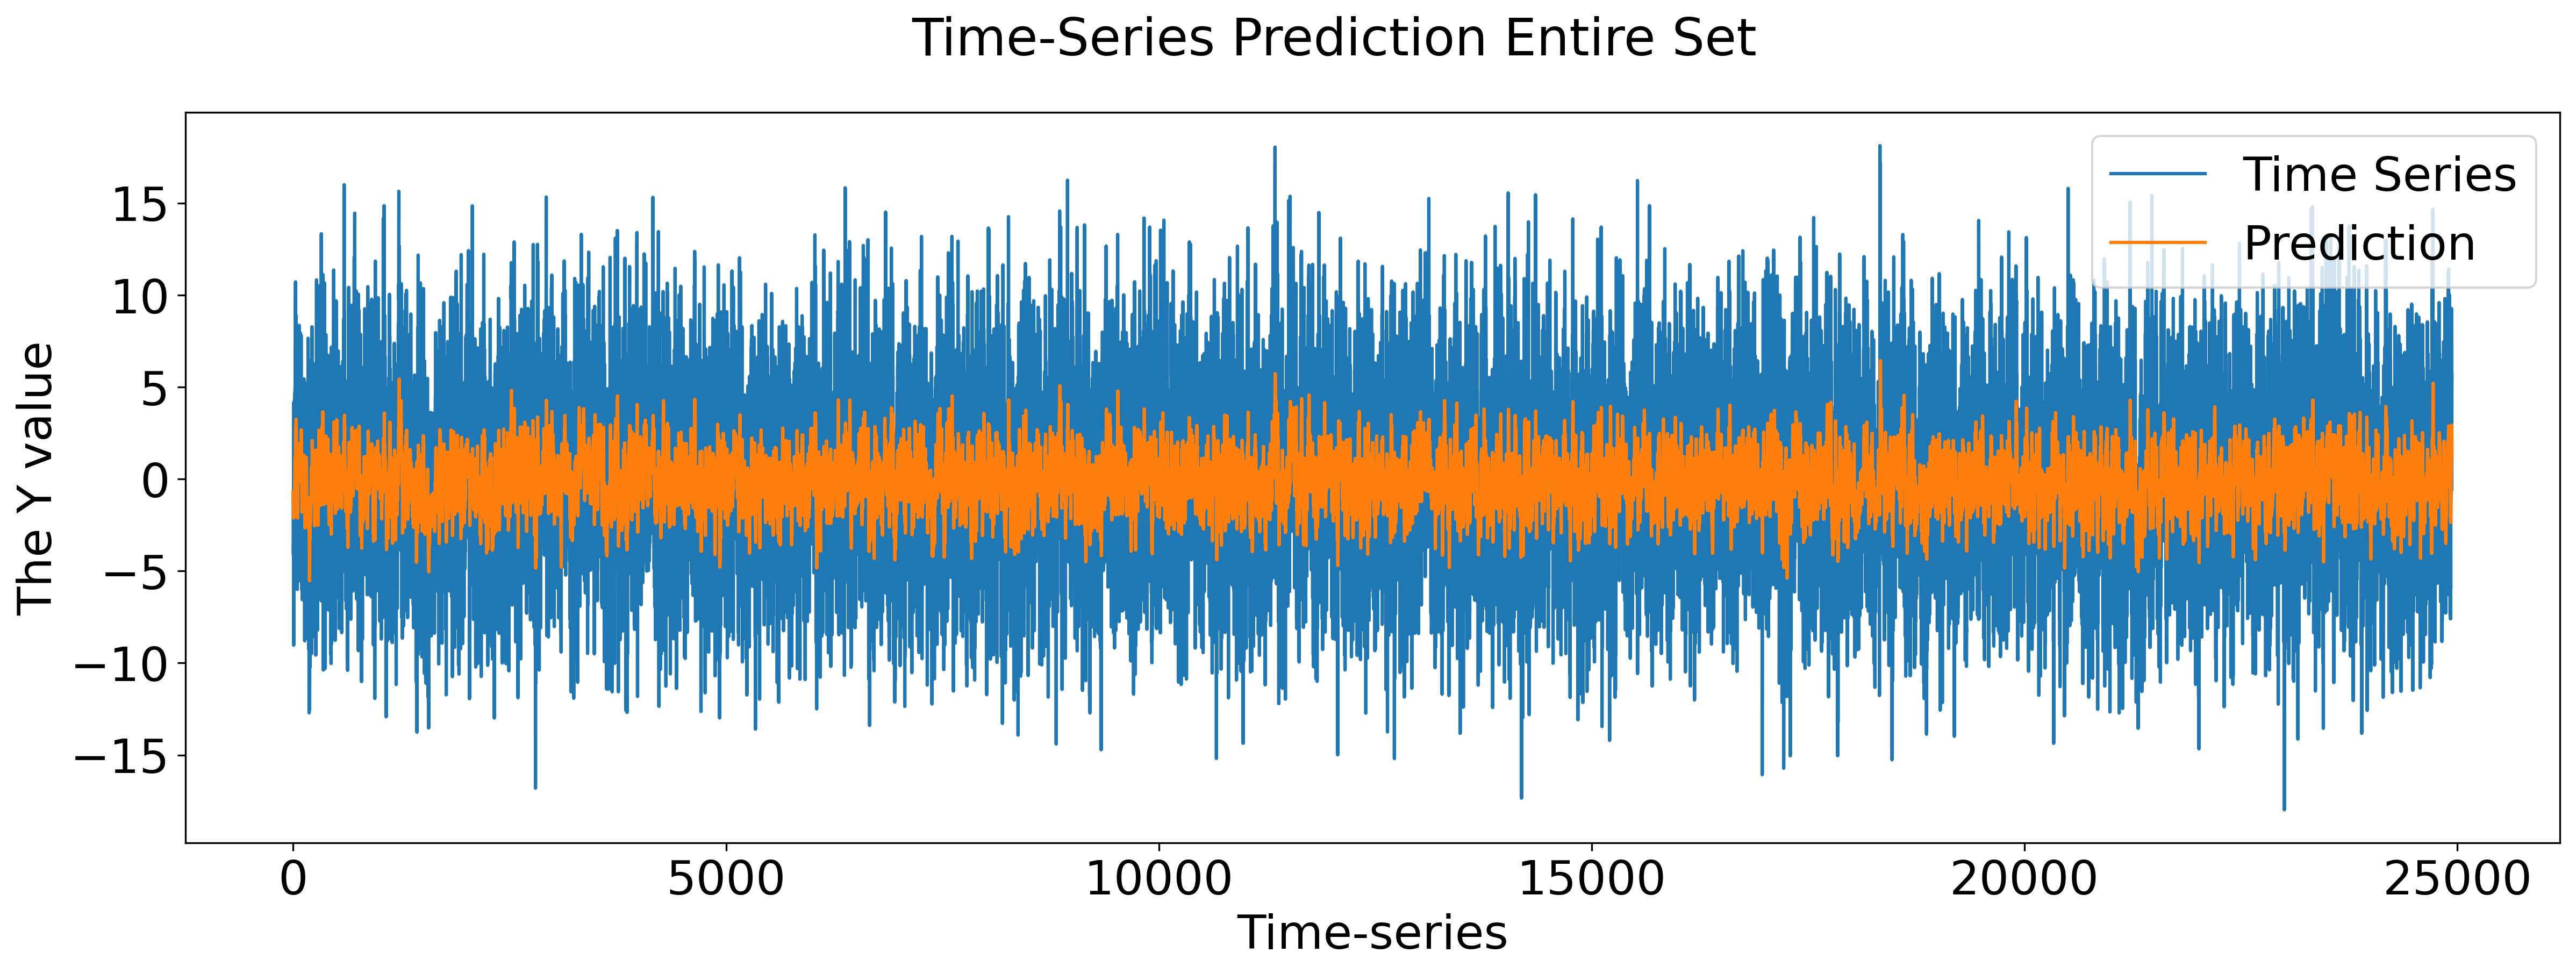

In [ ]:
# Prediction

lstm.eval()
train_predict = lstm(test_dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = test_dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_labels = pd.DataFrame(dataY_plot)

# Plot 
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction',],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Time-series',fontsize = 21)
plt.show()

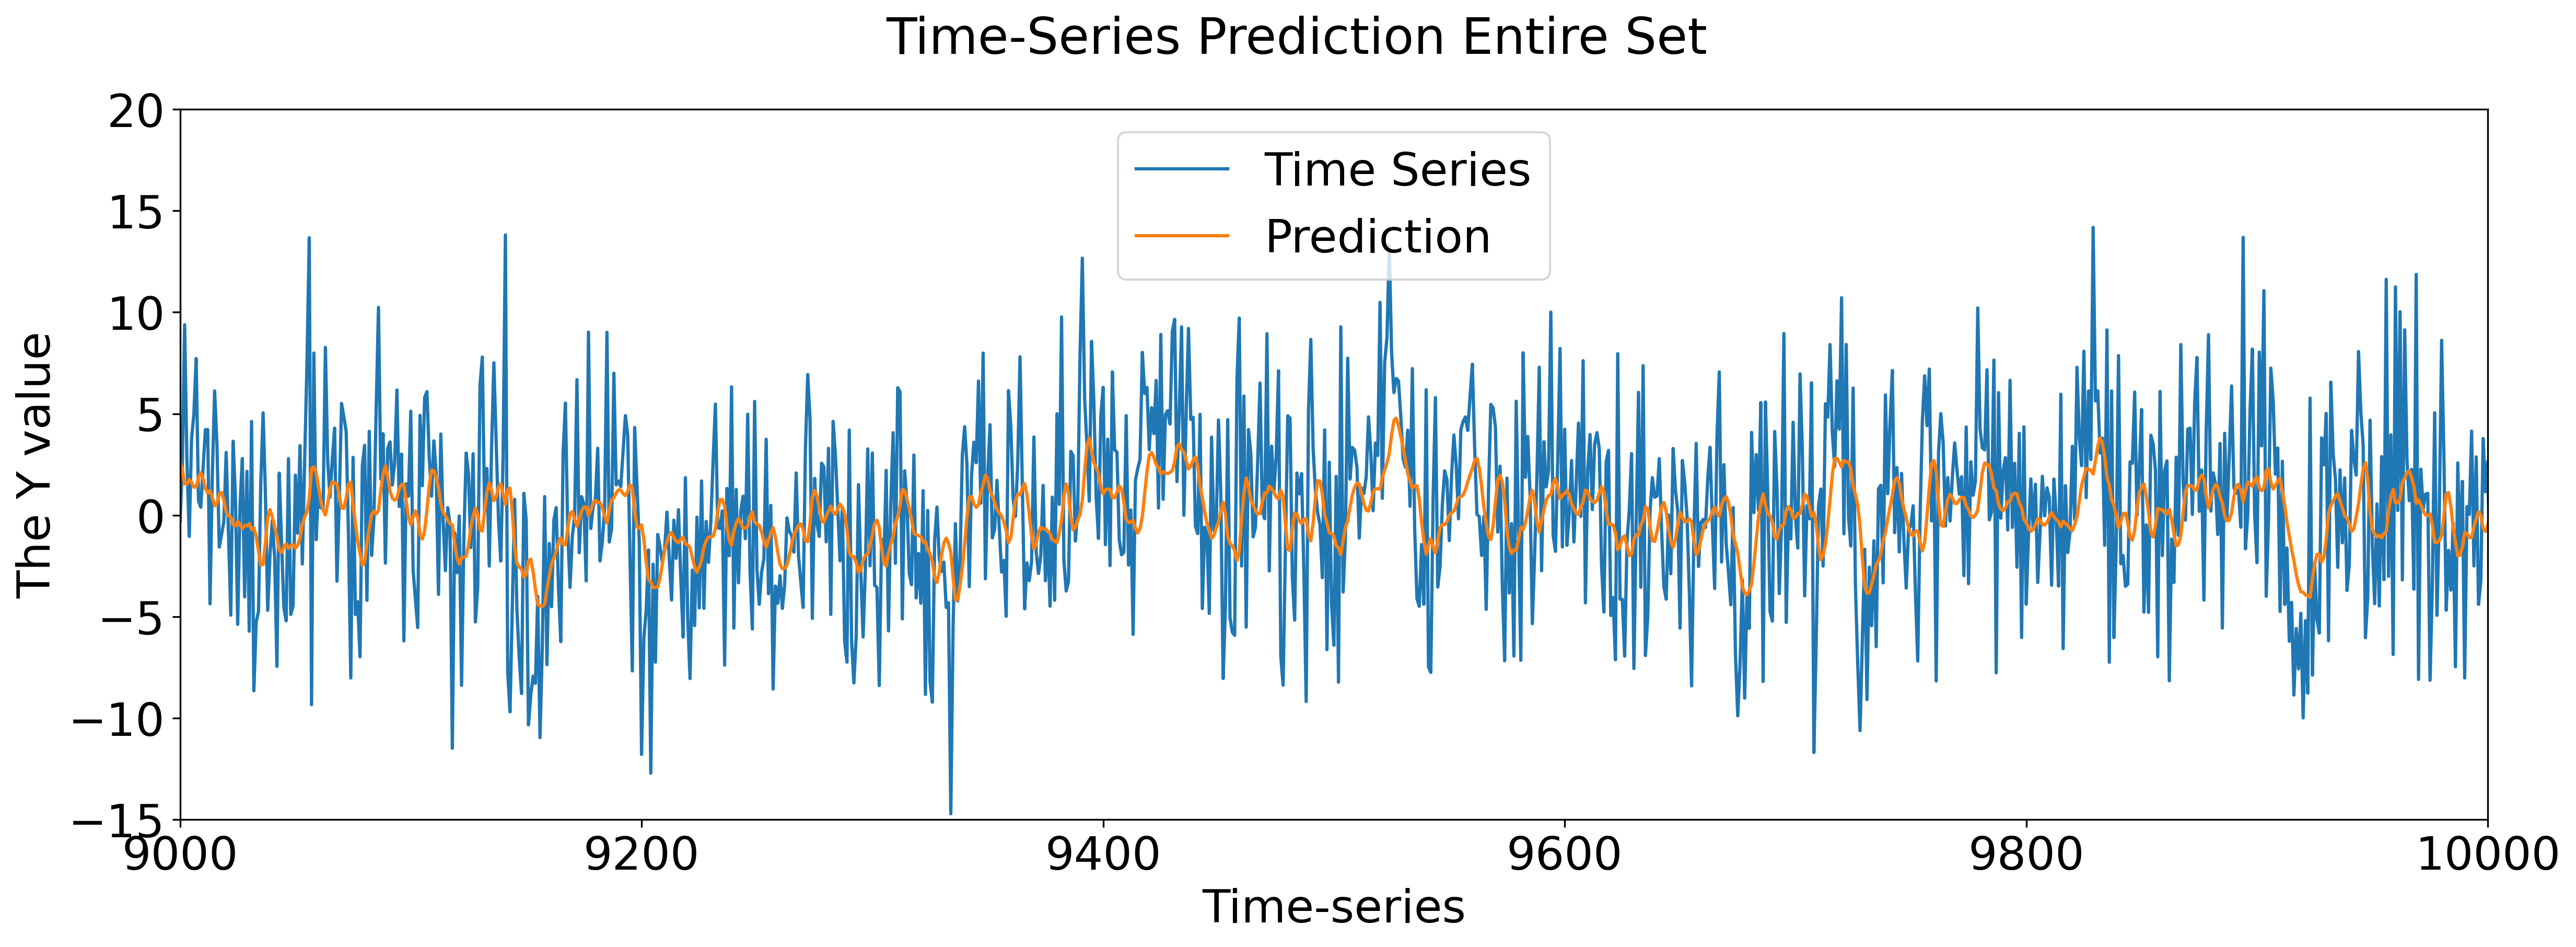

In [ ]:

# Plotting last 1000 events in time series
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Time-series',fontsize = 21)
plt.axis([9000, 10000, -15, 20])
plt.show()

In [ ]:

print('root mean square error: ', mean_squared_error(df_labels[0], df_predict[0]))
print('R2: ',r2_score(df_labels[0], df_predict[0]))

root mean square error:  18.413994
R2:  0.10956990805055966
